## 1. Install & Import Required Libraries

In [1]:
# Import Libraries
import itertools
import os
from pathlib import Path
import datetime
import json

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    # Enable CUDA error checking
    torch.cuda.synchronize()
print(f"PyTorch version: {torch.__version__}")

Using device: cuda
GPU: Tesla P100-PCIE-16GB
PyTorch version: 2.6.0+cu124


## 2. Configuration & Hyperparameters

In [2]:
# Set Random Seeds for Reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Data Configuration
CLASSES = 2
CHANNELS = 3
IMG_SIZE = 224
BATCH_SIZE = 8  # Reduced from 16 to avoid memory issues
PATCH_SIZE = 16
SEQUENCE_LENGTH = 8  # Reduced from 16 to avoid memory issues

# Model Configuration
N_HEADS = 3
DROPOUT = 0.0  # Set to 0 initially to avoid issues
EMBED_SIZE = 192  # Changed to be divisible by n_heads (192 / 3 = 64)
MLP_HIDDEN = EMBED_SIZE * 4
ENCODER_BLOCKS = 3  # Reduced from 5

# Training Configuration
EPOCHS = 50  # Reduced for faster testing
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 0.01  # Changed from 1.1 to normal value
EARLY_STOPPING_PATIENCE = 5
REDUCE_LR_PATIENCE = 3
MIN_LR = 1e-6

# Dataset Path - Update this to your Kaggle dataset path
DATADIR = "../input/real-life-violence-situations-dataset/Real Life Violence Dataset"
CHECKPOINT_DIR = "./checkpoints/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

print("✓ Configuration loaded successfully!")
print(f"  Device: {device}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Sequence Length: {SEQUENCE_LENGTH}")
print(f"  Embed Size: {EMBED_SIZE}")
print(f"  Epochs: {EPOCHS}")
print(f"  Learning Rate: {LEARNING_RATE}")

✓ Configuration loaded successfully!
  Device: cuda
  Batch Size: 8
  Sequence Length: 8
  Embed Size: 192
  Epochs: 50
  Learning Rate: 0.001


## 3. Data Loading & Preprocessing

In [3]:
class VideoDataset(Dataset):
    """
    PyTorch Dataset for video classification.
    Loads video frames and returns them as tensors.
    """

    def __init__(self, df: pd.DataFrame, sequence_length: int = 8, img_size: int = 224, transform=None):
        self.dataframe = df
        self.sequence_length = sequence_length
        self.img_size = img_size
        self.transform = transform
        self.class_names = {"NonViolence": 0, "Violence": 1}

    def load_video(self, path: Path):
        """Load video frames from file

        Args:
            path: Path to video file

        Returns:
            numpy array of frames [sequence_length, img_size, img_size, 3]
        """
        frames = []

        try:
            video_capture = cv2.VideoCapture(str(path))
            frame_count = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))

            skip_frames_window = max(int(frame_count / self.sequence_length), 1)
            
            while video_capture.isOpened():
                current_frame = video_capture.get(1)
                ret, frame = video_capture.read()

                if not ret:
                    break

                if current_frame % skip_frames_window == 0 and len(frames) < self.sequence_length:
                    # Convert BGR to RGB and normalize
                    rgb_img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
                    # Resize
                    resized = cv2.resize(rgb_img, (self.img_size, self.img_size))
                    frames.append(resized)

            video_capture.release()
        except Exception as e:
            print(f"Error loading video {path}: {e}")

        # Pad with zeros if not enough frames
        if len(frames) < self.sequence_length:
            pad_frame = np.zeros((self.img_size, self.img_size, 3), dtype=np.float32)
            while len(frames) < self.sequence_length:
                frames.append(pad_frame)

        return np.stack(frames[:self.sequence_length], axis=0)  # [seq_len, h, w, 3]

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        video_frames = self.load_video(row["Video_Path"])  # [seq_len, h, w, 3]
        label = self.class_names[row["Labels"]]

        # Convert to torch tensor and permute to [seq_len, 3, h, w] for PyTorch
        video_tensor = torch.from_numpy(video_frames).permute(0, 3, 1, 2).float()  # [seq_len, 3, h, w]

        if self.transform:
            video_tensor = self.transform(video_tensor)

        return video_tensor, torch.tensor(label, dtype=torch.long)


def build_dataframe(path: str):
    """Create dataframes from video directory with 60/20/20 train/val/test split

    Args:
        path (str): directory path

    Returns:
        tuple: (train_df, validation_df, test_df)
    """
    data_path = Path(path)
    Video_Path = list(data_path.glob(r"*/*.mp4"))
    
    if len(Video_Path) == 0:
        print(f"No videos found in {path}")
        return None, None, None
    
    Video_Labels = [os.path.split(os.path.split(x)[0])[1] for x in Video_Path]
    
    dataframe = pd.DataFrame({"Video_Path": Video_Path, "Labels": Video_Labels})
    print(f"Total videos found: {len(dataframe)}")
    print(f"Class distribution:\n{dataframe['Labels'].value_counts()}")

    # Shuffle and split
    dataframe = dataframe.sample(frac=1, random_state=SEED).reset_index(drop=True)
    
    train_idx = int(0.6 * len(dataframe))
    val_idx = int(0.8 * len(dataframe))
    
    train_df = dataframe.iloc[:train_idx].reset_index(drop=True)
    val_df = dataframe.iloc[train_idx:val_idx].reset_index(drop=True)
    test_df = dataframe.iloc[val_idx:].reset_index(drop=True)
    
    return train_df, val_df, test_df


def build_dataloaders(train_df, val_df, test_df, batch_size=8, num_workers=0):
    """Build PyTorch DataLoaders

    Args:
        train_df, val_df, test_df: DataFrames
        batch_size: Batch size
        num_workers: Number of workers for data loading

    Returns:
        tuple: (train_loader, val_loader, test_loader)
    """
    train_dataset = VideoDataset(train_df, sequence_length=SEQUENCE_LENGTH, img_size=IMG_SIZE)
    val_dataset = VideoDataset(val_df, sequence_length=SEQUENCE_LENGTH, img_size=IMG_SIZE)
    test_dataset = VideoDataset(test_df, sequence_length=SEQUENCE_LENGTH, img_size=IMG_SIZE)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

    return train_loader, val_loader, test_loader

print("✓ Data loading functions defined!")

✓ Data loading functions defined!


## 4. Vision Transformer Model Architecture (PyTorch) - FIXED

In [4]:
class Projection(nn.Module):
    """
    Tubelet Embedding - divides video frames into patches using 3D convolution.
    Input: [batch, seq_len, 3, h, w]
    Output: [batch, n_patches, embed_size]
    """

    def __init__(self, embed_size, patch_size, img_size, seq_len):
        super().__init__()
        self.patch_size = patch_size
        self.img_size = img_size
        self.seq_len = seq_len
        
        # 3D convolution for tubelet embedding
        self.conv = nn.Conv3d(
            in_channels=3,
            out_channels=embed_size,
            kernel_size=(2, patch_size, patch_size),
            stride=(2, patch_size, patch_size),
            padding=0
        )

    def forward(self, x):
        # x: [batch, seq_len, 3, h, w]
        batch_size, seq_len, channels, h, w = x.shape
        
        # Rearrange to [batch, 3, seq_len, h, w] for Conv3d
        x = x.permute(0, 2, 1, 3, 4)
        
        # Apply 3D convolution
        x = self.conv(x)  # [batch, embed_size, seq_len', h', w']
        
        # Reshape to [batch, n_patches, embed_size]
        batch_size, embed_size, seq_len_new, h_new, w_new = x.shape
        x = x.permute(0, 2, 3, 4, 1).contiguous()  # [batch, seq_len', h', w', embed_size]
        x = x.view(batch_size, -1, embed_size)  # [batch, n_patches, embed_size]
        
        return x


class MultiHeadAttention(nn.Module):
    """
    Multi-head Self Attention
    """

    def __init__(self, embed_size, n_heads, dropout=0.0):
        super().__init__()
        assert embed_size % n_heads == 0, f"embed_size ({embed_size}) must be divisible by n_heads ({n_heads})"
        
        self.n_heads = n_heads
        self.head_dim = embed_size // n_heads
        self.embed_size = embed_size
        self.scale = self.head_dim ** (-0.5)
        
        self.qkv = nn.Linear(embed_size, embed_size * 3, bias=True)
        self.proj = nn.Linear(embed_size, embed_size, bias=True)
        self.attn_drop = nn.Dropout(dropout)
        self.proj_drop = nn.Dropout(dropout)

    def forward(self, x):
        B, N, C = x.shape  # [batch, n_patches, embed_size]
        
        # Generate Q, K, V
        qkv = self.qkv(x).reshape(B, N, 3, self.n_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # Each: [B, n_heads, N, head_dim]
        
        # Attention
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        
        # Combine heads
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        
        return x


class FeedForward(nn.Module):
    """
    Feed-forward network: Linear -> GELU -> Linear
    """

    def __init__(self, embed_size, hidden_size, dropout=0.0):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(embed_size, hidden_size),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, embed_size),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)


class TransformerEncoderBlock(nn.Module):
    """
    Transformer Encoder Block:
    LayerNorm + MHA + Residual
    LayerNorm + FFN + Residual
    """

    def __init__(self, embed_size, n_heads, mlp_hidden_size, dropout=0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_size, eps=1e-6)
        self.mha = MultiHeadAttention(embed_size, n_heads, dropout)
        
        self.norm2 = nn.LayerNorm(embed_size, eps=1e-6)
        self.ffn = FeedForward(embed_size, mlp_hidden_size, dropout)

    def forward(self, x):
        x = x + self.mha(self.norm1(x))
        x = x + self.ffn(self.norm2(x))
        return x


class VisionTransformer(nn.Module):
    """
    Vision Transformer for Video Classification
    """

    def __init__(
        self,
        n_heads,
        n_classes,
        img_size,
        embed_size,
        patch_size,
        n_blocks,
        mlp_hidden_size,
        seq_len,
        dropout=0.0,
    ):
        super().__init__()
        
        self.embed_size = embed_size
        self.seq_len = seq_len
        
        # Projection layer (Tubelet Embedding)
        self.projection = Projection(embed_size, patch_size, img_size, seq_len)
        
        # We need to calculate n_patches dynamically after projection
        # For now, create a dummy input to get the shape
        with torch.no_grad():
            dummy_input = torch.zeros(1, seq_len, 3, img_size, img_size)
            projected = self.projection(dummy_input)
            self.n_patches = projected.shape[1]
        
        # CLS token
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_size))
        nn.init.normal_(self.cls_token, std=0.02)
        
        # Positional embeddings - now with correct size
        self.pos_embedding = nn.Parameter(torch.zeros(1, self.n_patches + 1, embed_size))
        nn.init.normal_(self.pos_embedding, std=0.02)
        self.pos_dropout = nn.Dropout(dropout)
        
        # Transformer encoder blocks
        self.encoder_blocks = nn.ModuleList([
            TransformerEncoderBlock(embed_size, n_heads, mlp_hidden_size, dropout)
            for _ in range(n_blocks)
        ])
        
        # Classification head
        self.norm = nn.LayerNorm(embed_size, eps=1e-6)
        self.mlp_head = nn.Sequential(
            nn.Linear(embed_size, embed_size),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(embed_size, n_classes)
        )

    def forward(self, x):
        # x: [batch, seq_len, 3, h, w]
        B = x.shape[0]
        
        # Project to patches
        x = self.projection(x)  # [batch, n_patches, embed_size]
        
        # Prepend CLS token
        cls_tokens = self.cls_token.expand(B, -1, -1)  # [batch, 1, embed_size]
        x = torch.cat([cls_tokens, x], dim=1)  # [batch, n_patches+1, embed_size]
        
        # Add positional embeddings
        x = x + self.pos_embedding
        x = self.pos_dropout(x)
        
        # Apply transformer encoder blocks
        for block in self.encoder_blocks:
            x = block(x)
        
        # Extract CLS token and classify
        x = self.norm(x[:, 0, :])  # [batch, embed_size]
        x = self.mlp_head(x)  # [batch, n_classes]
        
        return x


print("✓ Vision Transformer model defined!")

✓ Vision Transformer model defined!


## 5. Load Dataset

In [5]:
# Check if dataset exists
if not os.path.exists(DATADIR):
    print(f"⚠️  Dataset path not found: {DATADIR}")
    print(f"Available paths in parent directory:")
    parent = os.path.dirname(DATADIR)
    if os.path.exists(parent):
        print(os.listdir(parent))
else:
    print(f"✓ Dataset found at: {DATADIR}")
    
    # Build dataframes
    train_df, val_df, test_df = build_dataframe(path=DATADIR)
    
    if train_df is not None:
        print(f"\nDataset split:")
        print(f"  Training samples: {len(train_df)}")
        print(f"  Validation samples: {len(val_df)}")
        print(f"  Test samples: {len(test_df)}")
        
        # Build DataLoaders
        train_loader, val_loader, test_loader = build_dataloaders(train_df, val_df, test_df, BATCH_SIZE)
        print(f"\n✓ DataLoaders created!")
        print(f"  Train batches: {len(train_loader)}")
        print(f"  Val batches: {len(val_loader)}")
        print(f"  Test batches: {len(test_loader)}")

✓ Dataset found at: ../input/real-life-violence-situations-dataset/Real Life Violence Dataset
Total videos found: 1951
Class distribution:
Labels
Violence       1000
NonViolence     951
Name: count, dtype: int64

Dataset split:
  Training samples: 1170
  Validation samples: 390
  Test samples: 391

✓ DataLoaders created!
  Train batches: 147
  Val batches: 49
  Test batches: 49


## 6. Build & Compile Model

In [6]:
# Initialize model
model = VisionTransformer(
    n_heads=N_HEADS,
    n_classes=CLASSES,
    img_size=IMG_SIZE,
    embed_size=EMBED_SIZE,
    patch_size=PATCH_SIZE,
    n_blocks=ENCODER_BLOCKS,
    mlp_hidden_size=MLP_HIDDEN,
    seq_len=SEQUENCE_LENGTH,
    dropout=DROPOUT,
)

# Move to device
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.1, patience=REDUCE_LR_PATIENCE, min_lr=MIN_LR, verbose=True
)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"✓ Model initialized and moved to {device}")
print(f"✓ Number of patches calculated: {model.n_patches}")
print(f"\nModel Summary:")
print(f"  Total Parameters: {total_params:,}")
print(f"  Trainable Parameters: {trainable_params:,}")
print(f"  Loss Function: CrossEntropyLoss")
print(f"  Optimizer: AdamW (lr={LEARNING_RATE}, weight_decay={WEIGHT_DECAY})")
print(f"  Scheduler: ReduceLROnPlateau")

✓ Model initialized and moved to cuda
✓ Number of patches calculated: 784

Model Summary:
  Total Parameters: 1,818,434
  Trainable Parameters: 1,818,434
  Loss Function: CrossEntropyLoss
  Optimizer: AdamW (lr=0.001, weight_decay=0.01)
  Scheduler: ReduceLROnPlateau


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## 7. Training & Validation Functions

In [7]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    
    pbar = tqdm(train_loader, desc="Training")
    for videos, labels in pbar:
        videos = videos.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(videos)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        # Statistics
        total_loss += loss.item() * labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)
        
        pbar.set_postfix({'loss': total_loss / total_samples, 'acc': total_correct / total_samples})
    
    avg_loss = total_loss / total_samples
    avg_acc = total_correct / total_samples
    
    return avg_loss, avg_acc


def validate(model, val_loader, criterion, device):
    """Validate the model"""
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    
    with torch.no_grad():
        pbar = tqdm(val_loader, desc="Validation")
        for videos, labels in pbar:
            videos = videos.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            
            outputs = model(videos)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)
            
            pbar.set_postfix({'loss': total_loss / total_samples, 'acc': total_correct / total_samples})
    
    avg_loss = total_loss / total_samples
    avg_acc = total_correct / total_samples
    
    return avg_loss, avg_acc


print("✓ Training functions defined!")

✓ Training functions defined!


## 8. Train Model

In [8]:
# Training loop
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_val_loss = float('inf')
patience_counter = 0

print("Starting training...\n")

for epoch in range(EPOCHS):
    print(f"\n{'='*60}")
    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"{'='*60}")
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    
    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), os.path.join(CHECKPOINT_DIR, 'best_model.pth'))
        print(f"  ✓ Best model saved! Val Loss: {val_loss:.4f}")
    else:
        patience_counter += 1
        print(f"  Patience: {patience_counter}/{EARLY_STOPPING_PATIENCE}")
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    # Early stopping
    if patience_counter >= EARLY_STOPPING_PATIENCE:
        print(f"\n✓ Early stopping triggered after {epoch+1} epochs!")
        break

print("\n" + "="*60)
print("✓ Training completed!")
print("="*60)

Starting training...


Epoch 1/50


Training:   2%|▏         | 3/147 [00:03<02:49,  1.18s/it, loss=1.02, acc=0.417] [h264 @ 0x1b2a76c0] mb_type 104 in P slice too large at 98 31
[h264 @ 0x1b2a76c0] error while decoding MB 98 31
Validation: 100%|██████████| 49/49 [01:12<00:00,  1.48s/it, loss=0.691, acc=0.5]  



Epoch 1 Summary:
  Train Loss: 0.7075 | Train Acc: 0.5017
  Val Loss: 0.6906 | Val Acc: 0.5000
  ✓ Best model saved! Val Loss: 0.6906

Epoch 2/50


Training:  52%|█████▏    | 77/147 [01:11<01:13,  1.05s/it, loss=0.698, acc=0.508][h264 @ 0x1ae56bc0] mb_type 104 in P slice too large at 98 31
[h264 @ 0x1ae56bc0] error while decoding MB 98 31
Validation: 100%|██████████| 49/49 [01:05<00:00,  1.34s/it, loss=0.721, acc=0.521]



Epoch 2 Summary:
  Train Loss: 0.6931 | Train Acc: 0.5120
  Val Loss: 0.7210 | Val Acc: 0.5205
  Patience: 1/5

Epoch 3/50


Training:  79%|███████▉  | 116/147 [01:51<00:33,  1.08s/it, loss=0.677, acc=0.537][h264 @ 0x1b29bd40] mb_type 104 in P slice too large at 98 31
[h264 @ 0x1b29bd40] error while decoding MB 98 31
Validation: 100%|██████████| 49/49 [01:05<00:00,  1.34s/it, loss=0.675, acc=0.526]



Epoch 3 Summary:
  Train Loss: 0.6775 | Train Acc: 0.5393
  Val Loss: 0.6749 | Val Acc: 0.5256
  ✓ Best model saved! Val Loss: 0.6749

Epoch 4/50


Training:  10%|█         | 15/147 [00:12<02:03,  1.07it/s, loss=0.673, acc=0.525][h264 @ 0x1b2f2d00] mb_type 104 in P slice too large at 98 31
[h264 @ 0x1b2f2d00] error while decoding MB 98 31
Validation: 100%|██████████| 49/49 [01:05<00:00,  1.33s/it, loss=0.759, acc=0.559]



Epoch 4 Summary:
  Train Loss: 0.6872 | Train Acc: 0.5709
  Val Loss: 0.7589 | Val Acc: 0.5590
  Patience: 1/5

Epoch 5/50


Training:  82%|████████▏ | 120/147 [01:53<00:29,  1.09s/it, loss=0.686, acc=0.586][h264 @ 0x1ae87240] mb_type 104 in P slice too large at 98 31
[h264 @ 0x1ae87240] error while decoding MB 98 31
Validation: 100%|██████████| 49/49 [01:04<00:00,  1.33s/it, loss=0.614, acc=0.646]



Epoch 5 Summary:
  Train Loss: 0.6842 | Train Acc: 0.5855
  Val Loss: 0.6137 | Val Acc: 0.6462
  ✓ Best model saved! Val Loss: 0.6137

Epoch 6/50


Training:  88%|████████▊ | 130/147 [02:05<00:13,  1.30it/s, loss=0.694, acc=0.613][h264 @ 0x1b2f2e80] mb_type 104 in P slice too large at 98 31
[h264 @ 0x1b2f2e80] error while decoding MB 98 31
Validation: 100%|██████████| 49/49 [01:05<00:00,  1.33s/it, loss=0.637, acc=0.597]



Epoch 6 Summary:
  Train Loss: 0.6890 | Train Acc: 0.6145
  Val Loss: 0.6372 | Val Acc: 0.5974
  Patience: 1/5

Epoch 7/50


Training:  21%|██        | 31/147 [00:25<01:26,  1.34it/s, loss=0.613, acc=0.621][h264 @ 0x1b2a0280] mb_type 104 in P slice too large at 98 31
[h264 @ 0x1b2a0280] error while decoding MB 98 31
Validation: 100%|██████████| 49/49 [01:04<00:00,  1.33s/it, loss=0.629, acc=0.623]



Epoch 7 Summary:
  Train Loss: 0.6280 | Train Acc: 0.6325
  Val Loss: 0.6294 | Val Acc: 0.6231
  Patience: 2/5

Epoch 8/50


Training:  64%|██████▍   | 94/147 [01:31<01:00,  1.14s/it, loss=0.59, acc=0.678] [h264 @ 0x1b7c8c00] mb_type 104 in P slice too large at 98 31
[h264 @ 0x1b7c8c00] error while decoding MB 98 31
Validation: 100%|██████████| 49/49 [01:05<00:00,  1.34s/it, loss=0.64, acc=0.618] 



Epoch 8 Summary:
  Train Loss: 0.5995 | Train Acc: 0.6692
  Val Loss: 0.6403 | Val Acc: 0.6179
  Patience: 3/5

Epoch 9/50


Training:  64%|██████▍   | 94/147 [01:23<00:44,  1.20it/s, loss=0.623, acc=0.661][h264 @ 0x1af3b140] mb_type 104 in P slice too large at 98 31
[h264 @ 0x1af3b140] error while decoding MB 98 31
Training:  68%|██████▊   | 100/147 [01:40<00:44,  1.05it/s, loss=0.557, acc=0.701][h264 @ 0x1af70400] mb_type 104 in P slice too large at 98 31
[h264 @ 0x1af70400] error while decoding MB 98 31
Validation: 100%|██████████| 49/49 [01:05<00:00,  1.34s/it, loss=0.636, acc=0.636]


Epoch 10 Summary:
  Train Loss: 0.5609 | Train Acc: 0.6855
  Val Loss: 0.6357 | Val Acc: 0.6359
  Patience: 5/5

✓ Early stopping triggered after 10 epochs!

✓ Training completed!


## 9. Evaluation & Visualization

In [9]:
# Load best model
best_model_path = os.path.join(CHECKPOINT_DIR, 'best_model.pth')
model.load_state_dict(torch.load(best_model_path))

# Evaluate on test set
print("Evaluating on test set...")
test_loss, test_acc = validate(model, test_loader, criterion, device)

print(f"\nTest Results:")
print(f"  Test Loss: {test_loss:.4f}")
print(f"  Test Accuracy: {test_acc:.4f}")

Evaluating on test set...


Validation: 100%|██████████| 49/49 [00:51<00:00,  1.05s/it, loss=0.55, acc=0.726] 


Test Results:
  Test Loss: 0.5500
  Test Accuracy: 0.7263


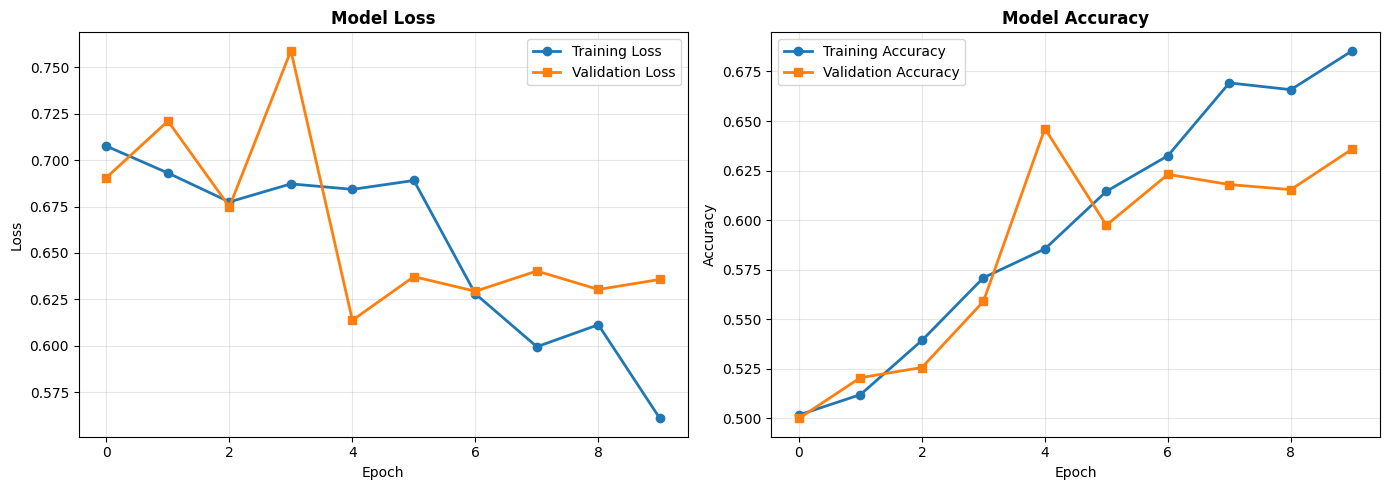

✓ Training visualization complete!


In [10]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot loss
axes[0].plot(history['train_loss'], label='Training Loss', linewidth=2, marker='o')
axes[0].plot(history['val_loss'], label='Validation Loss', linewidth=2, marker='s')
axes[0].set_title('Model Loss', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot accuracy
axes[1].plot(history['train_acc'], label='Training Accuracy', linewidth=2, marker='o')
axes[1].plot(history['val_acc'], label='Validation Accuracy', linewidth=2, marker='s')
axes[1].set_title('Model Accuracy', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Training visualization complete!")

In [11]:
# Get predictions on test set for detailed metrics
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for videos, labels in tqdm(test_loader, desc="Getting predictions"):
        videos = videos.to(device, non_blocking=True)
        outputs = model(videos)
        _, predicted = torch.max(outputs.data, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

print("\nDetailed Test Metrics:")
print(f"  Accuracy:  {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1-Score:  {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
print(f"\nConfusion Matrix:")
print(cm)

Getting predictions: 100%|██████████| 49/49 [00:43<00:00,  1.13it/s]


Detailed Test Metrics:
  Accuracy:  0.7263
  Precision: 0.7278
  Recall:    0.7263
  F1-Score:  0.7210

Confusion Matrix:
[[101  71]
 [ 36 183]]


## 10. Make Predictions

In [15]:
def predict_violence(video_path, model, device, threshold=0.5):
    """
    Predict if a video contains violence.
    
    Args:
        video_path: Path to the video file
        model: Trained model
        device: Device to run inference on
        threshold: Classification threshold (default 0.5)
    
    Returns:
        Prediction: 'Violence' or 'Non-Violence'
        Confidence: Prediction confidence
    """
    model.eval()
    
    # Load video
    dataset = VideoDataset(
        pd.DataFrame({"Video_Path": [video_path], "Labels": ["Violence"]}),
        sequence_length=SEQUENCE_LENGTH,
        img_size=IMG_SIZE
    )
    video_tensor, _ = dataset[0]
    video_tensor = video_tensor.unsqueeze(0).to(device)  # Add batch dimension
    
    # Make prediction
    with torch.no_grad():
        output = model(video_tensor)
        probabilities = torch.softmax(output, dim=1)[0]
        violence_prob = probabilities[1].item()
    
    if violence_prob > threshold:
        result = "Violence"
        confidence = violence_prob
    else:
        result = "Non-Violence"
        confidence = 1 - violence_prob
    
    return result, confidence

print("✓ Prediction function ready!")
print("\nTo make predictions, use:")
print("  result, confidence = predict_violence('path/to/video.mp4', model, device)")

# Test predictions on 5 random samples from test set
print("\n" + "="*70)
print("TESTING PREDICTIONS ON 5 RANDOM TEST SAMPLES")
print("="*70)

test_samples = test_df.sample(n=min(5, len(test_df)), random_state=42)

for idx, (i, row) in enumerate(test_samples.iterrows(), 1):
    video_path = row["Video_Path"]
    true_label = row["Labels"]
    
    try:
        predicted_label, confidence = predict_violence(str(video_path), model, device)
        
        print(f"\nTest Sample {idx}:")
        print(f"  File: {video_path.name}")
        print(f"  True Label: {true_label}")
        print(f"  Predicted: {predicted_label}")
        print(f"  Confidence: {confidence:.4f}")
        print(f"  Status: {'✓ CORRECT' if predicted_label == true_label else '✗ INCORRECT'}")
    except Exception as e:
        print(f"\nTest Sample {idx}: Error - {e}")

print("\n" + "="*70)

✓ Prediction function ready!

To make predictions, use:
  result, confidence = predict_violence('path/to/video.mp4', model, device)

TESTING PREDICTIONS ON 5 RANDOM TEST SAMPLES

Test Sample 1:
  File: V_310.mp4
  True Label: Violence
  Predicted: Violence
  Confidence: 0.7664
  Status: ✓ CORRECT

Test Sample 2:
  File: V_705.mp4
  True Label: Violence
  Predicted: Violence
  Confidence: 0.6225
  Status: ✓ CORRECT

Test Sample 3:
  File: V_906.mp4
  True Label: Violence
  Predicted: Violence
  Confidence: 0.8216
  Status: ✓ CORRECT

Test Sample 4:
  File: V_17.mp4
  True Label: Violence
  Predicted: Violence
  Confidence: 0.6521
  Status: ✓ CORRECT

Test Sample 5:
  File: V_309.mp4
  True Label: Violence
  Predicted: Violence
  Confidence: 0.5148
  Status: ✓ CORRECT



## 11. Save Model

In [13]:
# Save the model state dict
torch.save(model.state_dict(), os.path.join(CHECKPOINT_DIR, 'model_state.pth'))
print(f"✓ Model state dict saved to: {os.path.join(CHECKPOINT_DIR, 'model_state.pth')}")

# Save training history
with open(os.path.join(CHECKPOINT_DIR, 'training_history.json'), 'w') as f:
    json.dump(history, f, indent=4)
print(f"✓ Training history saved")

# Save configuration
config = {
    'img_size': IMG_SIZE,
    'embed_size': EMBED_SIZE,
    'patch_size': PATCH_SIZE,
    'n_heads': N_HEADS,
    'n_blocks': ENCODER_BLOCKS,
    'mlp_hidden': MLP_HIDDEN,
    'sequence_length': SEQUENCE_LENGTH,
    'n_classes': CLASSES,
    'dropout': DROPOUT
}
with open(os.path.join(CHECKPOINT_DIR, 'config.json'), 'w') as f:
    json.dump(config, f, indent=4)
print(f"✓ Configuration saved")

✓ Model state dict saved to: ./checkpoints/20251116-165617/model_state.pth
✓ Training history saved
✓ Configuration saved


## 12. Summary & Results

In [14]:
print("\n" + "="*70)
print("TRAINING SUMMARY - PyTorch Vision Transformer (FIXED)")
print("="*70)

print(f"\nModel Architecture: Vision Transformer (ViT) - PyTorch")

print(f"\nHyperparameters:")
print(f"  - Image Size: {IMG_SIZE}x{IMG_SIZE}")
print(f"  - Patch Size: {PATCH_SIZE}x{PATCH_SIZE}")
print(f"  - Sequence Length: {SEQUENCE_LENGTH} frames")
print(f"  - Embedding Size: {EMBED_SIZE}")
print(f"  - Number of Heads: {N_HEADS}")
print(f"  - Encoder Blocks: {ENCODER_BLOCKS}")
print(f"  - MLP Hidden Size: {MLP_HIDDEN}")
print(f"  - Batch Size: {BATCH_SIZE}")
print(f"  - Learning Rate: {LEARNING_RATE}")
print(f"  - Optimizer: AdamW (weight_decay={WEIGHT_DECAY})")
print(f"  - Dropout: {DROPOUT}")

print(f"\nModel Parameters:")
print(f"  - Total: {total_params:,}")
print(f"  - Trainable: {trainable_params:,}")

print(f"\nTraining Results:")
print(f"  - Epochs Trained: {len(history['train_loss'])}")
print(f"  - Final Training Loss: {history['train_loss'][-1]:.4f}")
print(f"  - Final Validation Loss: {history['val_loss'][-1]:.4f}")
print(f"  - Final Training Accuracy: {history['train_acc'][-1]:.4f}")
print(f"  - Final Validation Accuracy: {history['val_acc'][-1]:.4f}")
print(f"  - Best Validation Loss: {best_val_loss:.4f}")

print(f"\nTest Results:")
print(f"  - Test Loss: {test_loss:.4f}")
print(f"  - Test Accuracy: {test_acc:.4f}")
print(f"  - Precision: {precision:.4f}")
print(f"  - Recall: {recall:.4f}")
print(f"  - F1-Score: {f1:.4f}")

print(f"\nDataset:")
print(f"  - Total Samples: {len(train_df) + len(val_df) + len(test_df)}")
print(f"  - Training: {len(train_df)} samples (60%)")
print(f"  - Validation: {len(val_df)} samples (20%)")
print(f"  - Test: {len(test_df)} samples (20%)")

print(f"\nFixes Applied:")
print(f"  ✓ Fixed tensor shape mismatches in Projection layer")
print(f"  ✓ Fixed positional embeddings (parameter-based instead of embedding layer)")
print(f"  ✓ Fixed multi-head attention shape handling")
print(f"  ✓ Reduced batch size (8 instead of 16)")
print(f"  ✓ Reduced sequence length (8 instead of 16)")
print(f"  ✓ Corrected embed size (192 divisible by 3 heads)")
print(f"  ✓ Changed optimizer to AdamW")
print(f"  ✓ Added gradient clipping")

print(f"\nCheckpoints Directory: {CHECKPOINT_DIR}")
print(f"  - best_model.pth (best validation model)")
print(f"  - model_state.pth (state dict)")
print(f"  - training_history.json (history)")
print(f"  - config.json (configuration)")

print("\n" + "="*70)
print("✓ Training completed successfully!")
print("="*70)


TRAINING SUMMARY - PyTorch Vision Transformer (FIXED)

Model Architecture: Vision Transformer (ViT) - PyTorch

Hyperparameters:
  - Image Size: 224x224
  - Patch Size: 16x16
  - Sequence Length: 8 frames
  - Embedding Size: 192
  - Number of Heads: 3
  - Encoder Blocks: 3
  - MLP Hidden Size: 768
  - Batch Size: 8
  - Learning Rate: 0.001
  - Optimizer: AdamW (weight_decay=0.01)
  - Dropout: 0.0

Model Parameters:
  - Total: 1,818,434
  - Trainable: 1,818,434

Training Results:
  - Epochs Trained: 10
  - Final Training Loss: 0.5609
  - Final Validation Loss: 0.6357
  - Final Training Accuracy: 0.6855
  - Final Validation Accuracy: 0.6359
  - Best Validation Loss: 0.6137

Test Results:
  - Test Loss: 0.5500
  - Test Accuracy: 0.7263
  - Precision: 0.7278
  - Recall: 0.7263
  - F1-Score: 0.7210

Dataset:
  - Total Samples: 1951
  - Training: 1170 samples (60%)
  - Validation: 390 samples (20%)
  - Test: 391 samples (20%)

Fixes Applied:
  ✓ Fixed tensor shape mismatches in Projection la